# Multilayer Tidal Calculations
In this cookbook we will explore how we can use TidalPy's multilayer tidal functions to calculate tidal heating as a function of radius.
Here we are using a propagation matrix technique (SVC16) that is only valid in the incompressible limit.

**References**:
- SVC16 : Sabadini, Vermeerson, & Cambiotti (2016, DOI: [10.1007/978-94-017-7552-6](https://doi.org/10.1007/978-94-017-7552-6).
- HH14  : Henning & Hurford (2014, DOI: [10.1088/0004-637X/789/1/30](https://doi.org/10.1088/0004-637X/789/1/30)).
- TB05  : Tobie et al. (2005), DOI: [10.1016/j.icarus.2005.04.006](https://doi.org/10.1016/j.icarus.2005.04.006).
- ID    : [IcyDwarf Code](https://github.com/MarcNeveu/IcyDwarf/blob/master/IcyDwarf/Thermal.h) written by Marc Neveu

## Build the planet

<IPython.core.display.Javascript object>


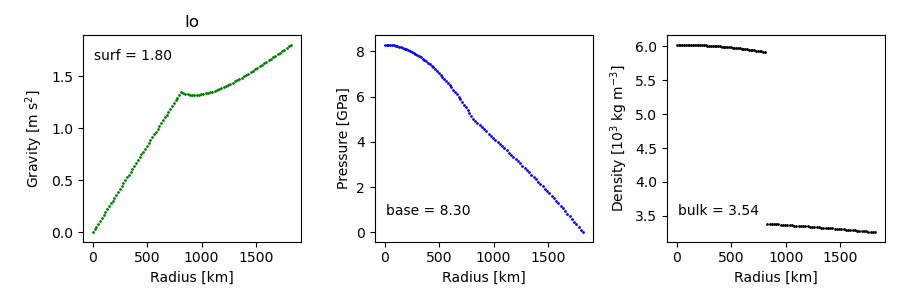

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from TidalPy import build_world
from TidalPy.utilities.numpy_helper import find_nearest
# For this example we will use the Io-Jupiter system
io = build_world('Io')
io.paint()
jupiter = build_world('Jupiter')
eccentricity = 0.0041
orbital_freq = 2. * np.pi / (86400. * 1.76914)

# We won't be using TidalPy's OOP approach (which currently does not use the multi-layer approach,
#    instead relying on a homogenous model broken up by layers), instead we will pull out a few parameters needed
#    for the multilayer calculations.
radius_array = io.radii
depth_array = (io.radius - radius_array)[::-1]
gravity_array = io.gravities
density_array = io.densities
pressure_array = io.pressures

# We will give the core and mantle a different viscoelastic state, but to do that we need to know what index
#   corresponds to the top of the core.
core_radius_cutoff = find_nearest(radius_array, io.core.radius)
mantle_N = len(radius_array[core_radius_cutoff:])
core_N = len(radius_array[:core_radius_cutoff])
total_N = len(radius_array)

# Determine some global properties
world_radius = radius_array[-1]
surface_gravity = gravity_array[-1]
mantle_bulk_density = np.average(density_array[core_radius_cutoff:])

<IPython.core.display.Javascript object>


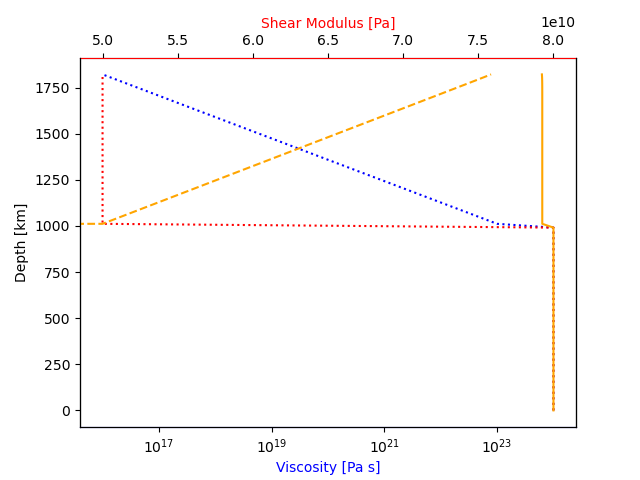

In [2]:
# Setup Io's viscoelastic state - this is not particularly accurate, just meant for demonstration purposes

# Tidal dissipation is not too sensitive to bulk modulus so we will keep it constant
bulk_moduli = 200.0e9 * np.ones_like(radius_array)
bulk_moduli[:core_radius_cutoff] = 800.0e9

# Shear modulus and viscosity is much more important, but to keep this example simple we will assume a
#   constant shear and an increasing viscosity towards the surface
shear_moduli = 50.0e9 * np.ones_like(radius_array)
shear_moduli[:core_radius_cutoff] = 80.0e9

viscosities = 1.e24 * np.ones_like(radius_array)
viscosities[core_radius_cutoff:] = np.logspace(23, 16, mantle_N)

# Now we can calculate the complex_compliance of the world. We will just use a Maxwell model here but several
#    others are available.
from TidalPy.rheology.complex_compliance.compliance_models import maxwell_array
complex_compliances = maxwell_array(orbital_freq, shear_moduli**(-1), viscosities)
# We will specifically turn off tidal dissipation in the core by setting the imaginary portion of
#    complex compliance = 0
complex_compliances[:core_radius_cutoff] = np.real(complex_compliances[:core_radius_cutoff]) + 1.e-12j * np.ones(core_N)
complex_shears = complex_compliances**(-1)

# Now let's see what this looks like
fig_visco, ax_visco = plt.subplots()
ax_shear = ax_visco.twiny()
ax_comp = ax_visco.twiny()
ax_comp.spines["top"].set_position(("axes", 1.2))

ax_visco.plot(viscosities, depth_array/1000., c='b', ls=':')
ax_shear.plot(shear_moduli, depth_array/1000., c='r', ls=':')
ax_comp.plot(np.real(complex_shears), depth_array/1000., c='orange', ls='-')
ax_comp.plot(np.imag(complex_shears), depth_array/1000., c='orange', ls='--')

ax_visco.set(ylabel='Depth [km]', xlabel='Viscosity [Pa s]', xscale='log')
ax_shear.set(xlabel='Shear Modulus [Pa]', xscale='linear')
ax_comp.set(xlabel='Complex Shear (Solid=Real, Dash=Imag) [Pa$^{-1}$]', xscale='log')
for ax, color in zip([ax_visco, ax_shear, ax_comp], ['b', 'r', 'orange']):
    if ax is ax_visco:
        ax.spines['bottom'].set_color(color)
    else:
        ax.spines['top'].set_color(color)
    ax.xaxis.label.set_color(color)

plt.show()

In [3]:
np.seterr(divide='raise')
# Load TidalPy's multilayer functions
from TidalPy.tides.multilayer import fundamental_matrix_orderl2, propagate, decompose

# Find the fundamental matrix; skip the innermost shell as that will be a boundary condition.
Y, Y_inv = fundamental_matrix_orderl2(radius_array[1:], complex_shears[1:], density_array[1:], gravity_array[1:])

In [4]:
# Propagate the tidal solution through the world's shells
central_boundary_condition = np.zeros((6, 3), dtype=np.complex128)
# Roberts & Nimmo (2000): Liquid innermost zone.
central_boundary_condition[2, 0] = 1.0
central_boundary_condition[3, 1] = 1.0
central_boundary_condition[5, 2] = 1.0

tidal_y = propagate(Y, Y_inv, central_boundary_condition, world_radius, order_l=2)

Surface Love & Shida Numbers
k_2 = 3.03e-02-3.59e-03j; h_2 = 1.65e-02-1.96e-03j; l_2 = 1.56e-09+5.31e-10j


<IPython.core.display.Javascript object>


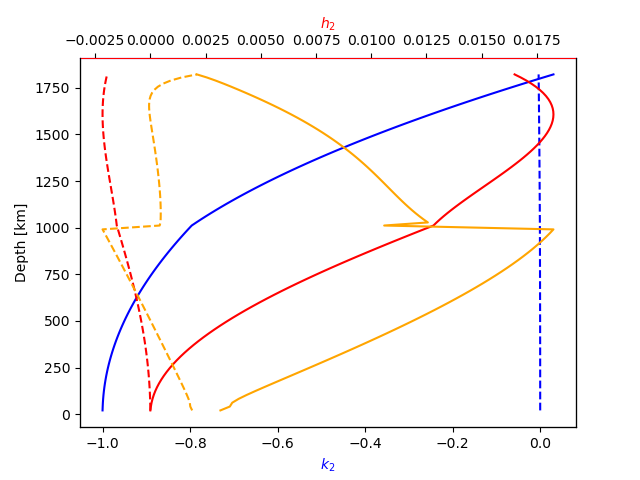

In [5]:
# Decompose the tidal solution into useful properties
radial_sensitivity_to_shear, (k2, h2, l2) = \
    decompose(tidal_y, radius_array[1:], gravity_array[1:], complex_shears[2:], bulk_moduli[2:], order_l=2)

print('Surface Love & Shida Numbers')
print(f'k_2 = {k2[-1]:.2e}; h_2 = {h2[-1]:.2e}; l_2 = {l2[-1]:.2e}')

# Let's plot these as a function of depth.
fig_love, ax_love_k = plt.subplots()
ax_love_h = ax_love_k.twiny()
ax_love_l = ax_love_k.twiny()
ax_love_l.spines["top"].set_position(("axes", 1.2))

ax_love_k.plot(np.real(k2), depth_array[1:]/1000., c='b', ls='-')
ax_love_k.plot(np.imag(k2), depth_array[1:]/1000., c='b', ls='--')
ax_love_h.plot(np.real(h2), depth_array[1:]/1000., c='r', ls='-')
ax_love_h.plot(np.imag(h2), depth_array[1:]/1000., c='r', ls='--')
ax_love_l.plot(np.real(l2), depth_array[1:]/1000., c='orange', ls='-')
ax_love_l.plot(np.imag(l2), depth_array[1:]/1000., c='orange', ls='--')

ax_love_k.set(title='Love Numbers (Solid=Real, Dash=Imag)')
ax_love_k.set(ylabel='Depth [km]', xlabel='$k_{2}$', xscale='linear')
ax_love_h.set(xlabel='$h_{2}$', xscale='linear')
ax_love_l.set(xlabel='$l_{2}$', xscale='linear')

for ax, color in zip([ax_love_k, ax_love_h, ax_love_l], ['b', 'r', 'orange']):
    if ax is ax_visco:
        ax.spines['bottom'].set_color(color)
    else:
        ax.spines['top'].set_color(color)
    ax.xaxis.label.set_color(color)

plt.show()

## Calculate Tidal Displacement
Utilizing the simplified tidal potential (low eccentricity, no obliquity, spin-synchronous).

In [6]:
from TidalPy.tides.potential.synchronous_low_e import tidal_potential

# Define latitude and longitude domain
latitude = np.linspace(-90., 90., 100)
longitude = np.linspace(0., 360., 100)
long_mtx, lat_mtx = np.meshgrid(np.radians(longitude), np.radians(latitude))

result_over_time = []

for time in np.linspace(0., 86400. * 2., 20):
    # Calculate the simplified tidal potential
    potenital, potential_dtheta, potential_dphi = \
        tidal_potential(world_radius, long_mtx, lat_mtx, orbital_freq, eccentricity, time)

    # Scale by the tidal solutions
    radial_displacement = tidal_y[0, -1] * potenital
    polar_displacement = tidal_y[2, -1] * potential_dtheta
    azimuthal_displacement = tidal_y[2, -1] * potential_dphi
    
    result_over_time.append((time / (60. * 60), radial_displacement, polar_displacement, azimuthal_displacement))

<IPython.core.display.Javascript object>


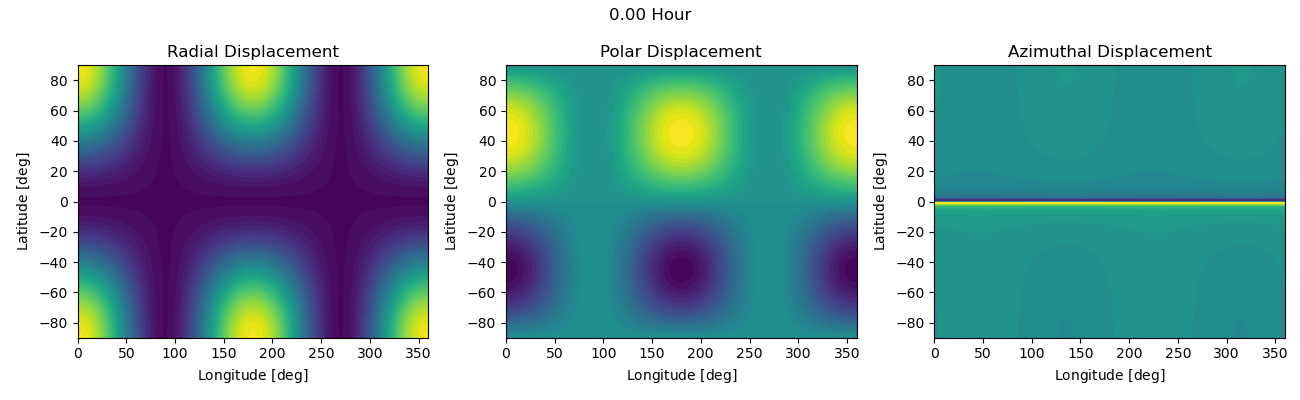

interactive(children=(IntSlider(value=0, description='time_i', max=19), Output()), _dom_classes=('widget-inter…

<function __main__.update(time_i=0)>

In [7]:
# Plot results
from ipywidgets import interact
fig_disp, axes_disp = plt.subplots(ncols=3, figsize=(13, 4))
plt.subplots_adjust(wspace=.5)
ax_r = axes_disp[0]
ax_r.set(ylabel='Latitude [$\deg$]', xlabel='Longitude [$\deg$]', title='Radial Displacement', xlim=(0, 360), ylim=(-90, 90))
ax_th = axes_disp[1]
ax_th.set(ylabel='Latitude [$\deg$]', xlabel='Longitude [$\deg$]', title='Polar Displacement', xlim=(0, 360), ylim=(-90, 90))
ax_phi = axes_disp[2]
ax_phi.set(ylabel='Latitude [$\deg$]', xlabel='Longitude [$\deg$]', title='Azimuthal Displacement', xlim=(0, 360), ylim=(-90, 90))
fig_disp.suptitle(f'0.00 Hour')

time_hr, u_r, u_th, u_phi = result_over_time[0]
ax_r.contourf(longitude, latitude, u_r, 40)
ax_th.contourf(longitude, latitude, u_th, 40)
ax_phi.contourf(longitude, latitude, u_phi, 40)

fig_disp.tight_layout()
plt.show()

def update(time_i=0):
    time_hr, u_r, u_th, u_phi = result_over_time[time_i]
    fig_disp.suptitle(f'{time_hr:0.2f} Hour')
    ax_r.contourf(longitude, latitude, u_r, 40)
    ax_th.contourf(longitude, latitude, u_th, 40)
    ax_phi.contourf(longitude, latitude, u_phi, 40)
    
    for ax in [ax_r, ax_th, ax_phi]:
        ax.relim()
        ax.autoscale_view()
    fig_disp.canvas.draw_idle()
    plt.show()

interact(update, time_i=(0, len(result_over_time)-1, 1))

## Performance
Here we are just doing a simple check on how the propagation functions perform